# **ODIN Project**: Petroleum Weekly Stocks
<img src="https://i.etsystatic.com/10828952/r/il/30b92c/4005527448/il_570xN.4005527448_eu18.jpg" width="500px">

In [268]:
import pymysql 
import pandas as pd 
import numpy as np 
import boto3 
import json 
import tensorflow as tf 
import pymysql 
import warnings 
import statsmodels.api as sm 
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

import seaborn as sns 
import matplotlib.pyplot as plt 

from typing import List, Dict 
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## **Load Petroleum Weekly Stocks** 

In [98]:
client = boto3.client('secretsmanager')
user,password,host,db,_ = list(json.loads(client.get_secret_value(SecretId='mysql_develoment').get('SecretString')).values())
con: 'MySQL' = pymysql.connect(user=user, passwd=password, db=db, host=host)

query: str = """ 
SELECT 
    %s
FROM petroleum_weekly_stocks p 
""" % (','.join(list(map(lambda item: 'p.%s' % (item), pd.read_sql('DESCRIBE petroleum_weekly_stocks', con=con ).iloc[1:-1, :1]['Field'].tolist() ))))

weekly_stocks: 'DataFrame' = pd.read_sql(query, con=con) 
weekly_stocks['period'] = pd.to_datetime(weekly_stocks['period'])
weekly_stocks['value'] = weekly_stocks['value'].astype(float) 
weekly_stocks['month_name'] = weekly_stocks['period'].apply(lambda row: row.month_name())
weekly_stocks['month'] = weekly_stocks['period'].apply(lambda row: row.month)

weekly_stocks.head() 

,index,period,duoarea,area_name,product,product_name,process,process_name,series,series_description,value,month_name
0,0,2023-10-20,R40,PADD 4,EPD0,Distillate Fuel Oil,SAE,Ending Stocks,WDISTP41,Rocky Mountain (PADD 4) Ending Stocks of Disti...,3715.0,October
1,1,2023-10-20,R30,PADD 3,EPLLPZ,Propane and Propylene,SAXP,Ending Stocks Excluding Propylene at Terminal,WPRSTP31,Gulf Coast (PADD 3) Propane and Propylene Endi...,59994.0,October
2,2,2023-10-20,R1Y,PADD 1B,EPLLPZ,Propane and Propylene,SAXP,Ending Stocks Excluding Propylene at Terminal,WPRST1B1,Central Atlantic (PADD 1B) Propane and Propyle...,6402.0,October
3,3,2023-10-20,R10,PADD 1,EPM0,Total Gasoline,SAE,Ending Stocks,WGTSTP11,East Coast (PADD 1) Ending Stocks of Total Gas...,56065.0,October
4,4,2023-10-20,R40,PADD 4,EPM0CO,Other Conventional Motor Gasoline,SAE,Ending Stocks,WG6ST_R40_1,Rocky Mountain (PADD 4) Ending Stocks of Other...,1111.0,October


## **Value in` MBBL` Descriptions** 

In [68]:
pd.DataFrame( weekly_stocks['value'].describe()).rename({'value': 'MBBL'}, axis=1)

,MBBL
count,4.970000e+03
mean,4.800995e+04
std,1.783345e+05
min,0.000000e+00
25%,3.842500e+02
50%,4.945000e+03
75%,2.637200e+04
max,1.629265e+06


## **Petroleum Stocks by `PADD` Districts and `Process Name`** 

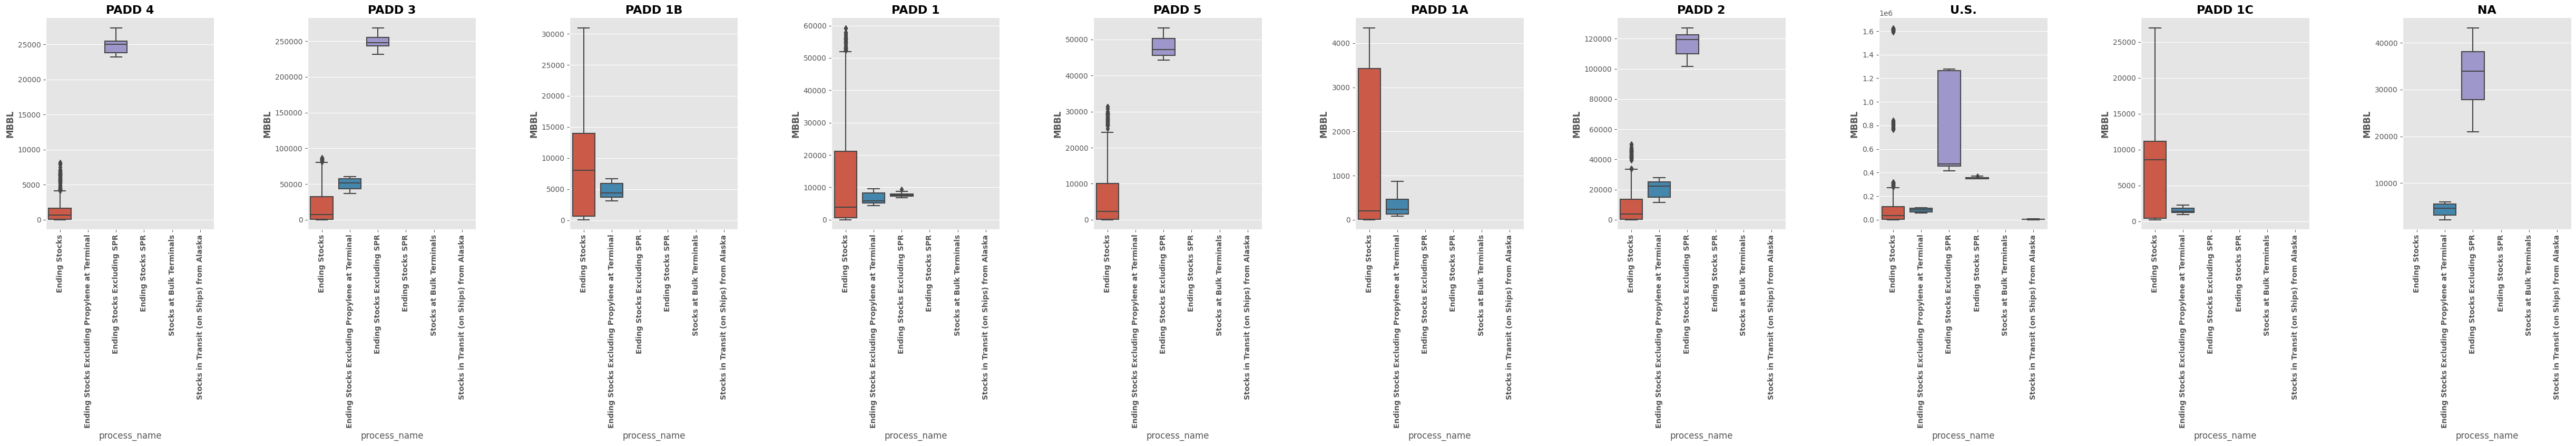

In [135]:
axis = sns.catplot(data=weekly_stocks[~weekly_stocks['area_name'].isna()], col='area_name', y='value', x='process_name', kind='box', sharey=False )
for ax in axis.axes.ravel():
    ax.set_title(ax.get_title().replace("area_name =", "" ).strip(), fontweight='bold', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='bold' )
    ax.set_ylabel("MBBL", fontweight='bold')

## **Histogram Weekly Petroleum Stocks by Process Name**

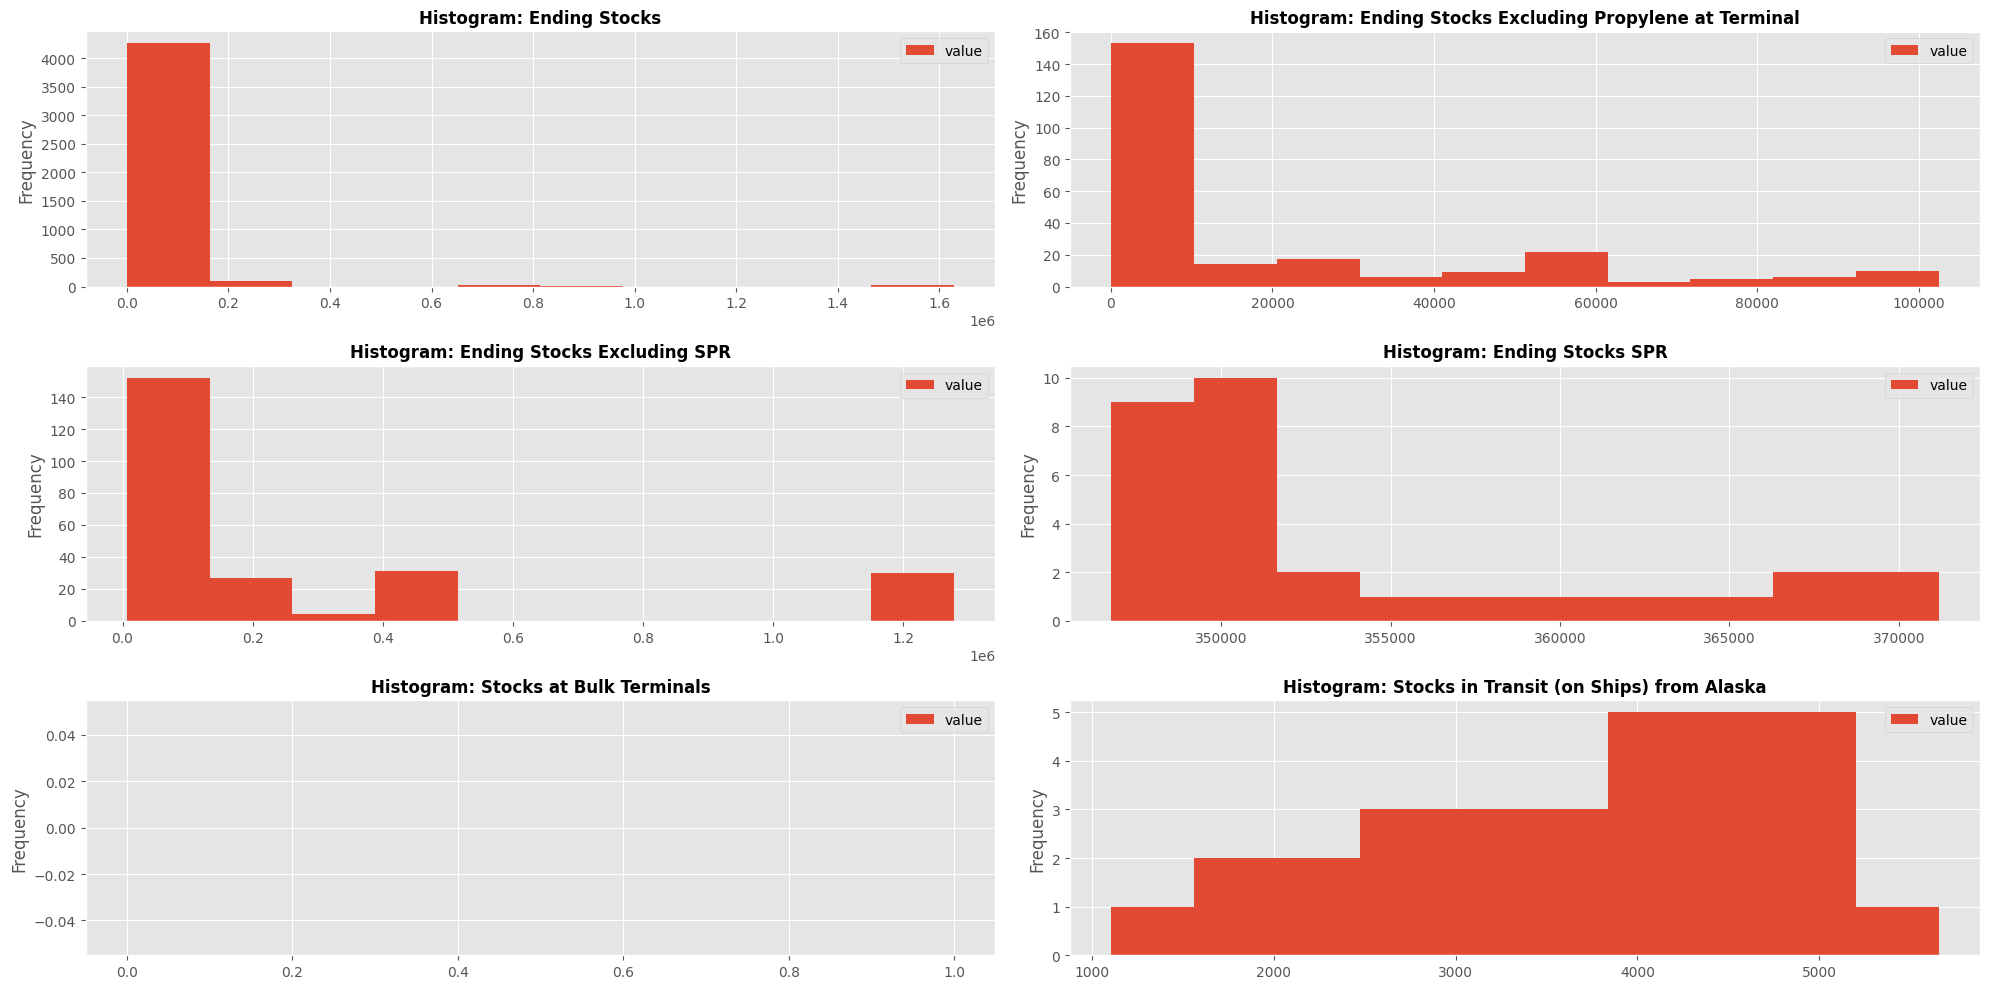

In [149]:
fig = plt.figure(figsize=(20,10)) 

for index,process_name in enumerate(weekly_stocks['process_name'].unique().tolist(), 1):
    ax= fig.add_subplot(3,2,index)
    weekly_stocks.query(f"process_name == '{process_name}' ").plot(kind='hist', by='process_name', column='value',  ax=ax)
    ax.set_title("Histogram: %s" % (process_name), fontweight='bold', fontsize=12 )

plt.tight_layout() 

## **Distribution of Petroleum by Product Name in `MBBL`**

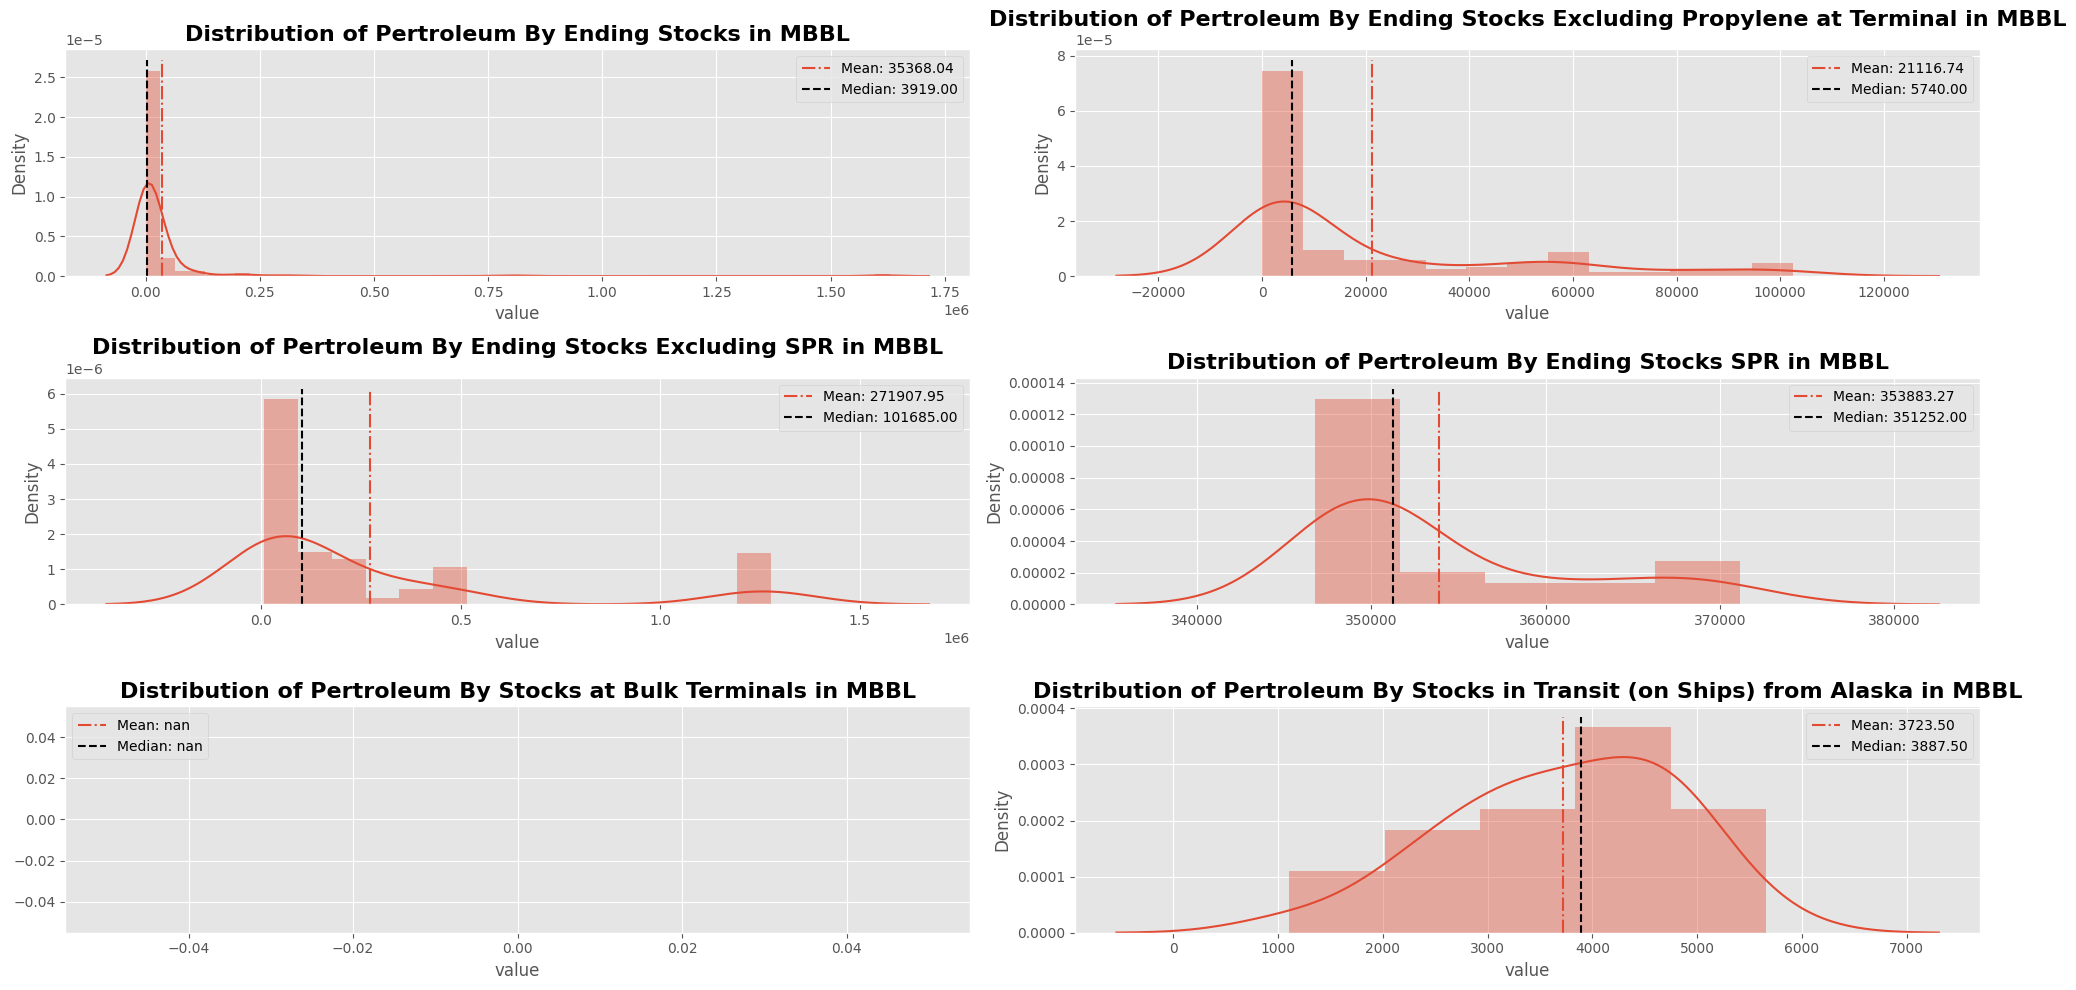

In [75]:
fig = plt.figure(figsize=(20,10)) 

for index,process_name in enumerate(weekly_stocks['process_name'].unique().tolist(),1):
    
    ax = fig.add_subplot(3,2,index)
    current_df: 'DataFrame' = weekly_stocks.query(f"process_name == '{process_name}' ")['value'] 
    sns.distplot(current_df, ax=ax)
    ax.set_title("Distribution of Pertroleum By %s in MBBL" % (process_name) , fontweight='bold', fontsize=16)
    ymin,ymax = ax.get_ylim()

    mean: float = current_df.mean() 
    median: float = current_df.median() 
    ax.vlines(x=mean, ymin=ymin, ymax=ymax, label=f"Mean: {mean:.2f}", linestyle="-.")
    ax.vlines(x=median, ymin=ymin, ymax=ymax, label=f"Median: {median:.2f}", linestyle="--", color='black')
    ax.legend()
    
plt.tight_layout() 

## **Weekly Trends in Petroleum Stocks by Product Name**

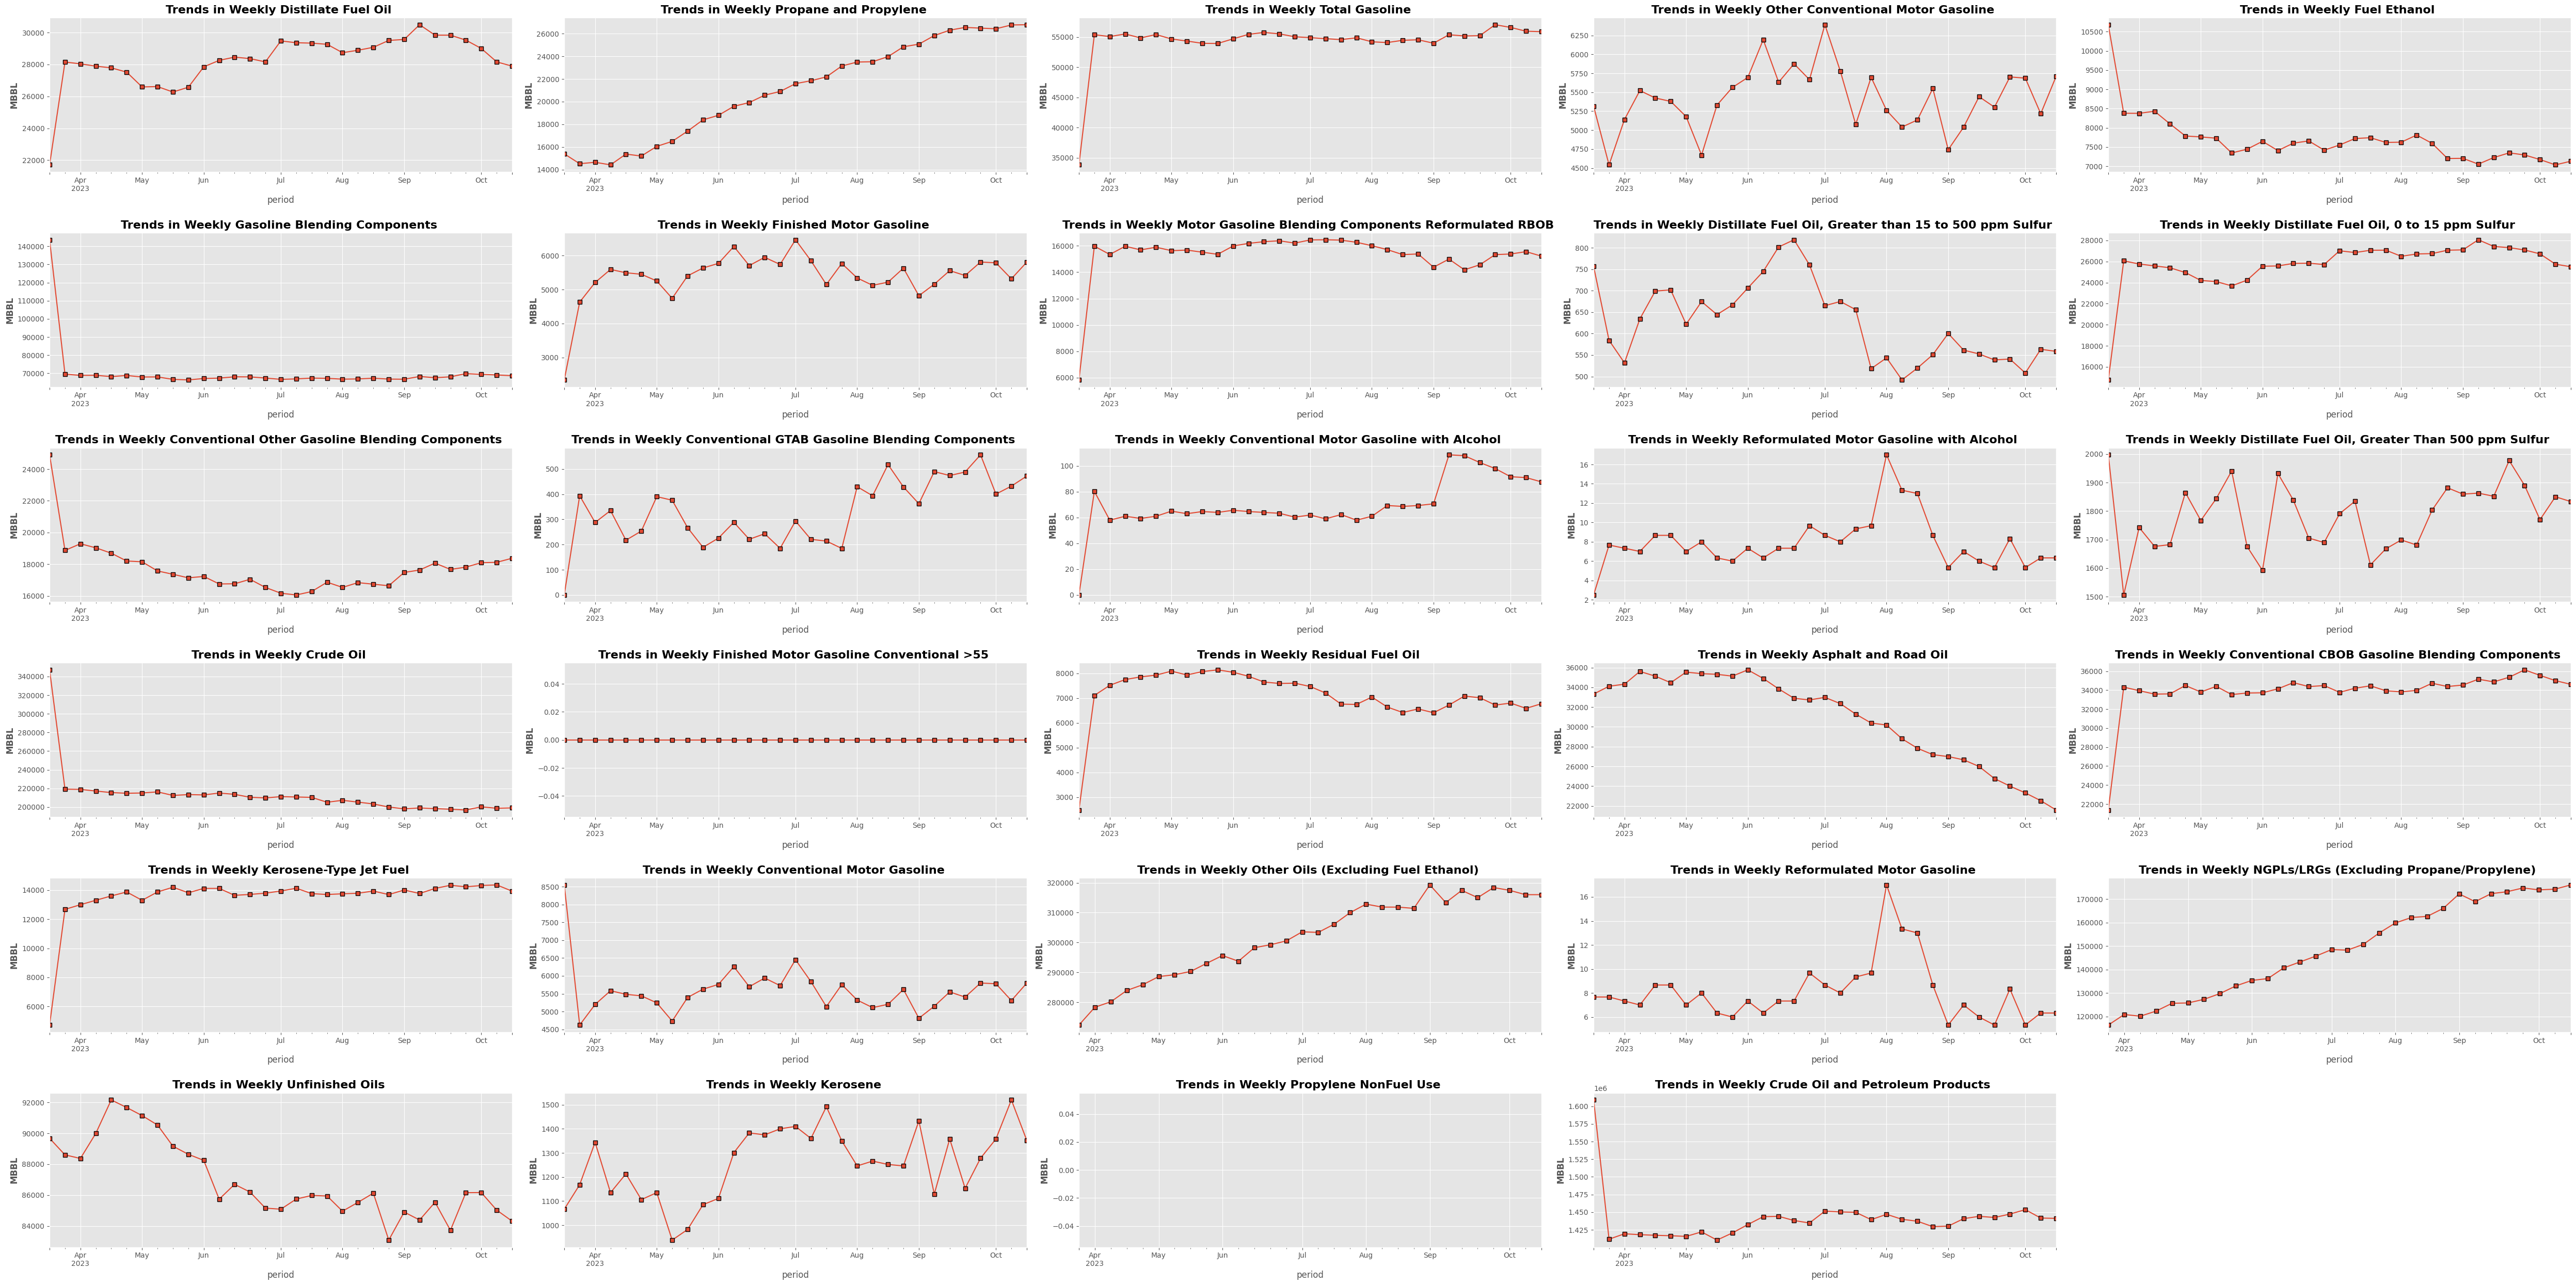

In [90]:
fig = plt.figure(figsize=(50,25))
for index,product_name in enumerate( weekly_stocks['product_name'].unique().tolist() ,1 ):
    ax = fig.add_subplot(6,5,index)
    weekly_stocks.query(f"product_name == '{product_name}' ").groupby('period')['value'].mean().plot(ax=ax, mec='black', marker='s')
    ax.set_title("Trends in Weekly %s " % (product_name), fontweight='bold', fontsize=16)
    ax.set_ylabel("MBBL", fontweight='bold')

plt.tight_layout()

## **Weekly `Crude Oil` and `Petroleum` Stocks by Month** 

In [162]:
weekly_stocks[ weekly_stocks['product_name'].apply(lambda row: 'crude' in row.lower()) ].groupby(['product', 'month'])['value'].mean().unstack('month').rename(dict(map(lambda item: (item[0],item[1]), weekly_stocks[['month','month_name']].drop_duplicates().sort_values(by='month').values.tolist())) ,axis=1)

month,March,April,May,June,July,August,September,October
product,,,,,,,,
EP00,1.477518e+06,1417923.00,1417271.25,1438666.20,1447800.125,1438442.5,1441043.80,1.445540e+06
EPC0,2.618143e+05,216559.65,214249.10,212346.72,209326.825,203913.8,197959.44,1.993029e+05


## **Modeling Weekly Petroleum Stocks** 

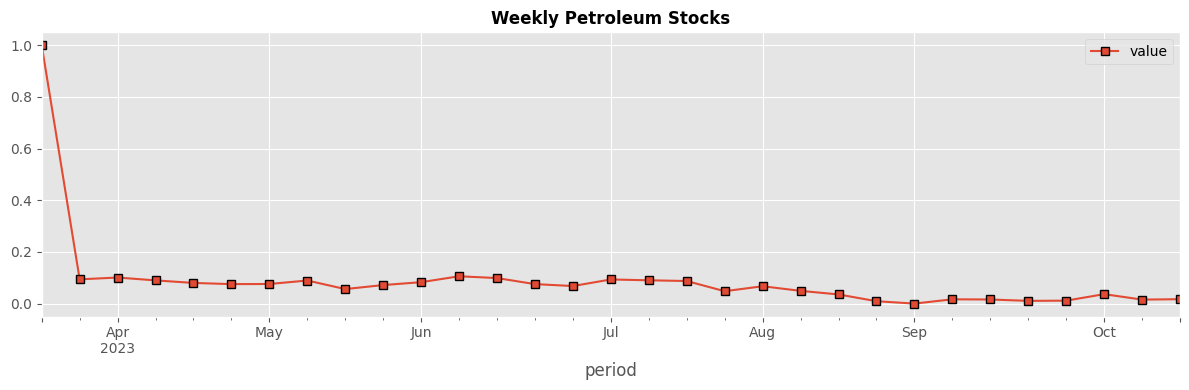

In [177]:
crude_oils: 'DataFrame' = weekly_stocks[ weekly_stocks['product_name'].apply(lambda row: 'crude' in row.lower()) ]
co_stocks: 'DataFrame' = pd.DataFrame(crude_oils.groupby('period')['value'].mean())
fig = plt.figure() 
ax = fig.add_subplot()
co_stocks.plot(figsize=(12,4), ax=ax, marker='s', mec='black' )
ax.set_title("Weekly Petroleum Stocks", fontweight='bold', fontsize=12)

plt.tight_layout() 

## **Modeling Crude Oil Weekly Stocks using `LSTM Neural Networks`**

In [224]:
scaler: MinMaxScaler = MinMaxScaler() 
co_stocks['value'] = scaler.fit_transform(co_stocks['value'].values.reshape(-1,1) )
stocks_df: 'DataFrame' = pd.DataFrame({ 'time' :co_stocks.index.tolist(), 'values':  co_stocks['value'].tolist() })
stocks_df['time'] = stocks_df['time'].apply(lambda row: row.timestamp())
sequence_length: int = 7 
X,y = [], []

for index in range(co_stocks.shape[0] - sequence_length):
    X.append(stocks_df[['time', 'values']][index: index + sequence_length].values)
    y.append(stocks_df['values'][ index + sequence_length] ) 

X = np.array(X)
y = np.array(y) 

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

### **Model One** 

In [226]:
model: 'LSTM' = tf.keras.models.Sequential([tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, 2)),
                                            tf.keras.layers.Dense(1), 
                                            tf.keras.layers.Dropout(0.2), # prevent overfitting
                                            tf.keras.layers.BatchNormalization()     
                                            ])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

residuals = (y_test - model.predict(X_test).flatten() ).tolist()  # residuals 

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 1.0168 - val_loss: 704.9772
Epoch 2/50
1/1 [==============================] - 0s 37ms/step - loss: 0.9898 - val_loss: 226.8252
Epoch 3/50
1/1 [==============================] - 0s 47ms/step - loss: 1.0080 - val_loss: 135.5394
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 0.9814 - val_loss: 52.9512
Epoch 5/50
1/1 [==============================] - 0s 37ms/step - loss: 1.0193 - val_loss: 47.7999
Epoch 6/50
1/1 [==============================] - 0s 43ms/step - loss: 0.9908 - val_loss: 76.5300
Epoch 7/50
1/1 [==============================] - 0s 36ms/step - loss: 1.0068 - val_loss: 60.8997
Epoch 8/50
1/1 [==============================] - 0s 37ms/step - loss: 1.0018 - val_loss: 51.9042
Epoch 9/50
1/1 [==============================] - 0s 38ms/step - loss: 0.9889 - val_loss: 45.9118
Epoch 10/50
1/1 [==============================] - 0s 37ms/step - loss: 0.9862 - val_loss: 38.7694
Epoch 11/50
1/1 [=

### **Evaluating Model One Residuals** 
- Show no autocorrelations after lag zero (errors are random)

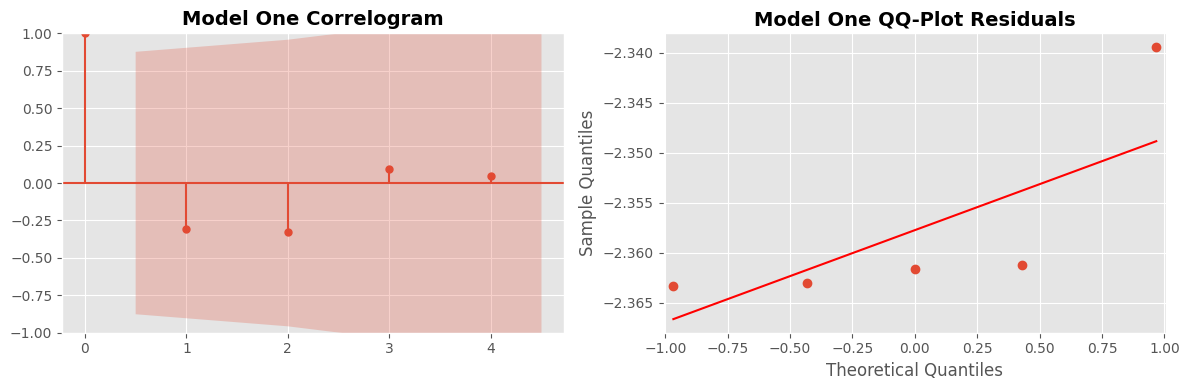

In [247]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot(1,2,1)
plot_acf(np.array(residuals),ax=ax)
ax.set_title("Model One Correlogram", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
sm.qqplot( np.array(residuals), line='s', ax=ax)
ax.set_title("Model One QQ-Plot Residuals", fontweight='bold', fontsize=14)
plt.tight_layout() 

### **LJungbox Tests Model One** 

In [233]:
acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,0.842894,0.35857


## **Washington States Crude Oils Import/Export**

In [258]:
wa_df: 'DataFrame' = pd.read_sql("""SELECT CAST(i.period AS DATETIME ) AS `timestamp`, 
                                            i.value 
                                    FROM import_export_washington i""", con=con).replace({np.nan:0.0} )

wa_stl = STL(wa_df.set_index('timestamp')['value'], period=7).fit()

## **Washington Seasonal Import/Export** 

<Axes: title={'center': 'Residuals WA Import/Export Crude Oils'}, xlabel='timestamp'>

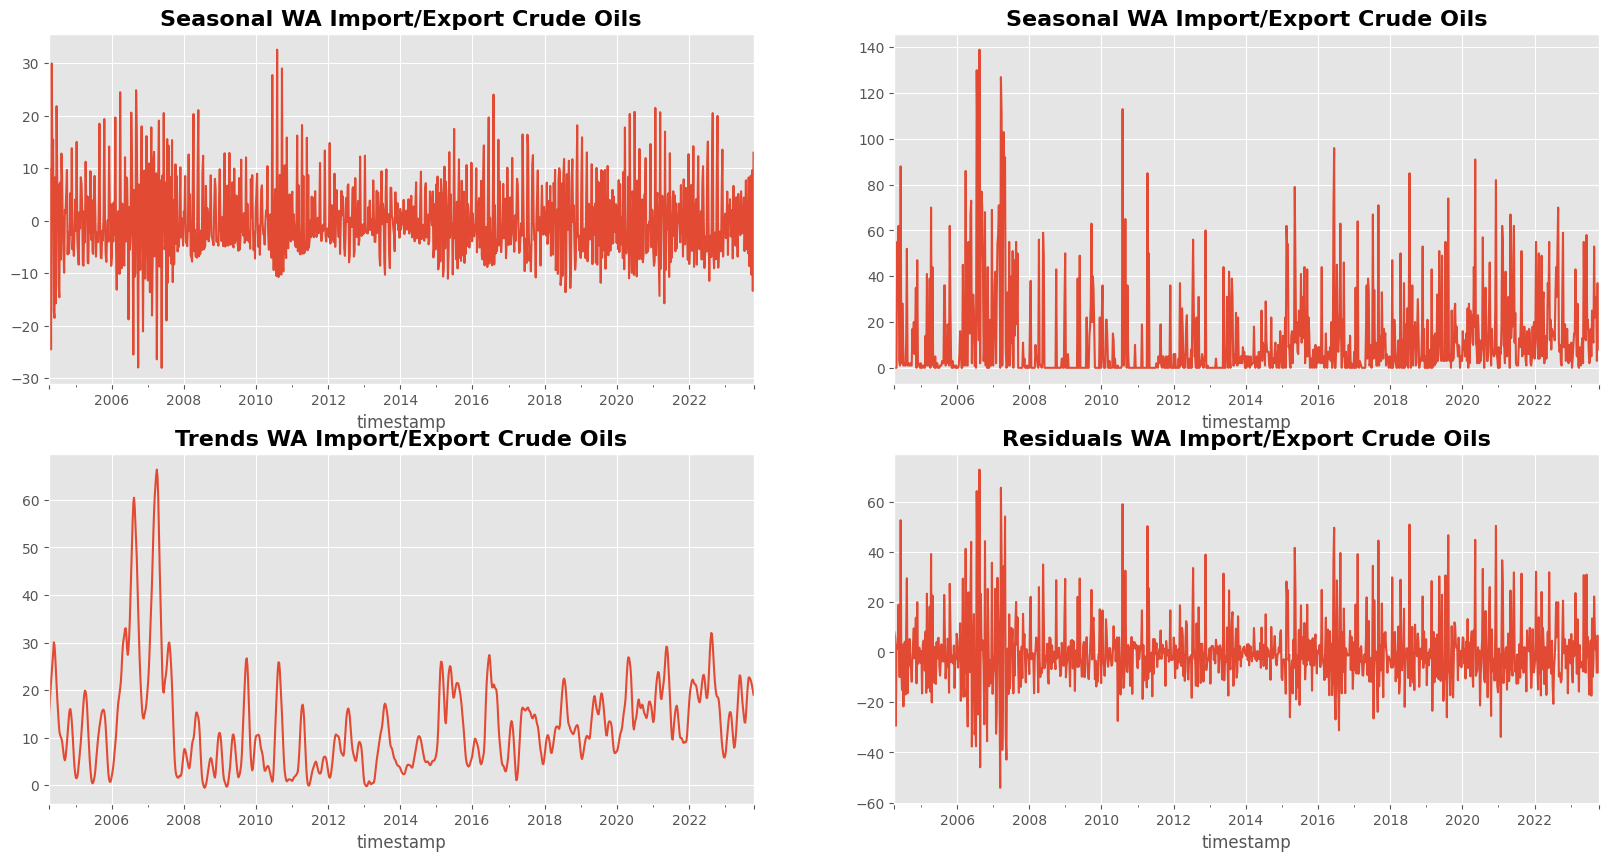

In [274]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,2,1) 
wa_stl.seasonal.plot(ax=ax) 
ax.set_title("Seasonal WA Import/Export Crude Oils", fontweight='bold', fontsize= 16)

ax = fig.add_subplot(2,2,2) 
ax.set_title("Seasonal WA Import/Export Crude Oils", fontweight='bold', fontsize= 16)
wa_stl.observed.plot(ax=ax)

ax = fig.add_subplot(2,2,3) 
ax.set_title("Trends WA Import/Export Crude Oils", fontweight='bold', fontsize= 16)
wa_stl.trend.plot(ax=ax)

ax = fig.add_subplot(2,2,4) 
ax.set_title("Residuals WA Import/Export Crude Oils", fontweight='bold', fontsize= 16)
wa_stl.resid.plot(ax=ax)

## **Weekly and Monthly Crude Oils Import/Export** 

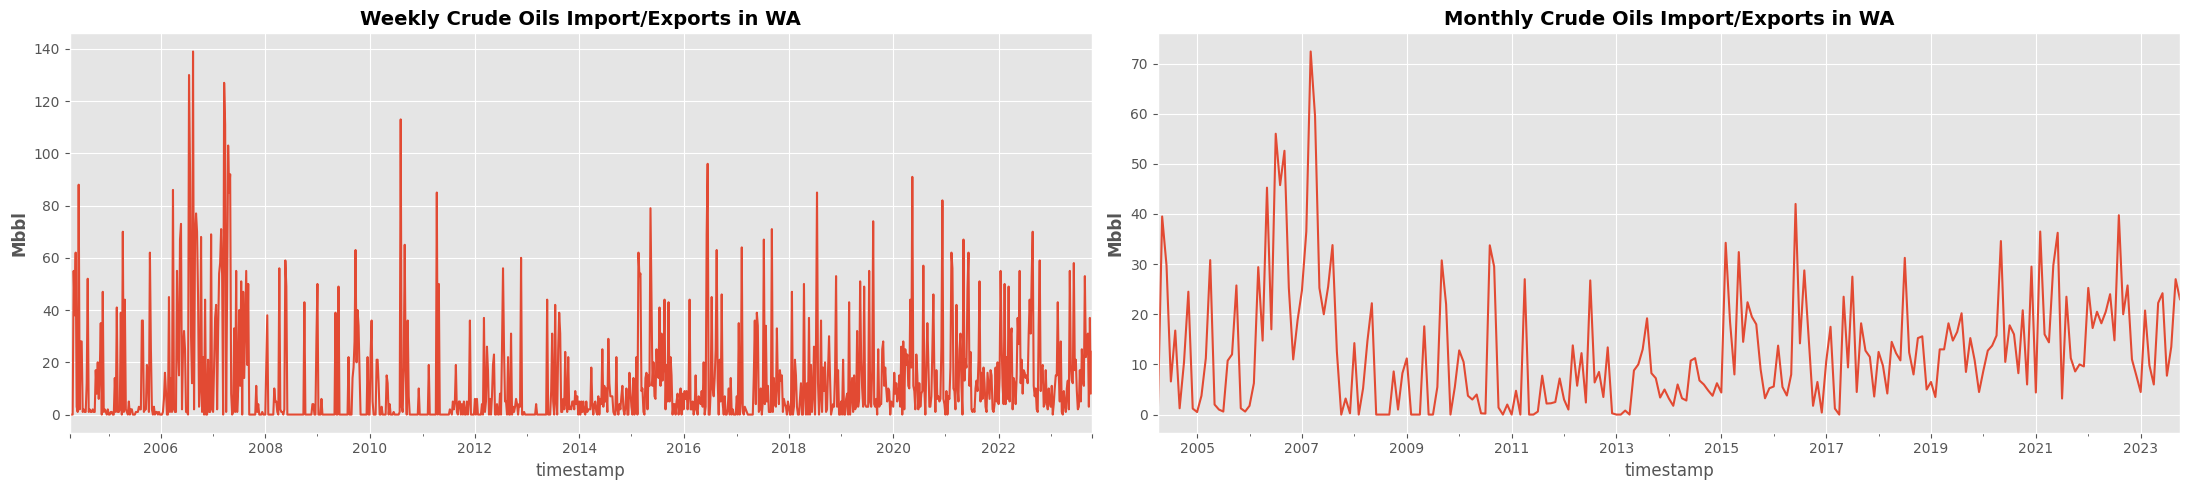

In [281]:
fig = plt.figure(figsize=(22,5)) 
ax = fig.add_subplot(1,2,1) 
wa_df.set_index("timestamp")['value'].plot(ax=ax)
ax.set_title("Weekly Crude Oils Import/Exports in WA", fontweight='bold', fontsize=14)
ax.set_ylabel("Mbbl", fontweight='bold')

ax = fig.add_subplot(1,2,2) 
wa_df.set_index('timestamp')['value'].resample('M').mean().plot() 
ax.set_title("Monthly Crude Oils Import/Exports in WA", fontweight='bold', fontsize=14)
ax.set_ylabel("Mbbl", fontweight='bold')
plt.tight_layout()

## **Modeling Crude Oil Weekly `Import/Export` using `LSTM Neural Networks`**

In [333]:
wa_df['time'] = wa_df['timestamp'].apply(lambda row: row.timestamp() )
wa_df['values'] = scaler.fit_transform(wa_df['value'].values.reshape(-1,1))
X,y = [], []

for index in range(wa_df.shape[0] - sequence_length):
    X.append(wa_df[['time', 'values']][index: index + sequence_length].values) 
    y.append(wa_df['values'][index + sequence_length] )

X = np.array(X)
y = np.array(y)

X1_train, X1_test, y1_train, y1_test = train_test_split(X,y, test_size=0.2, shuffle=False)

wa_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, 2)),
                                       tf.keras.layers.Dense(1, activation='relu'),
                                       tf.keras.layers.Dropout(0.4), 
                                       tf.keras.layers.BatchNormalization()
                                      ])

wa_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = wa_model.fit(X1_train,y1_train, epochs=50, batch_size=32, validation_data=(X1_test, y1_test), callbacks=[early_stopping])

residuals: float = y1_test - wa_model.predict(X1_test).flatten() # compute LSTM model residuals

Epoch 1/50
26/26 [==============================] - 2s 18ms/step - loss: 0.0192 - val_loss: 0.0553
Epoch 2/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0166 - val_loss: 0.0511
Epoch 3/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0152 - val_loss: 0.0485
Epoch 4/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0147 - val_loss: 0.0473
Epoch 5/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0465
Epoch 6/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0464
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0460
Epoch 8/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0458
Epoch 9/50
26/26 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0459
Epoch 10/50
26/26 [==============================] - 0s 10ms/step - loss: 0.0145 - val_loss: 0.0459
Epoch 11/50
26/2

## **Model Crude Oils `Import/Export` Training and Validation Loss**

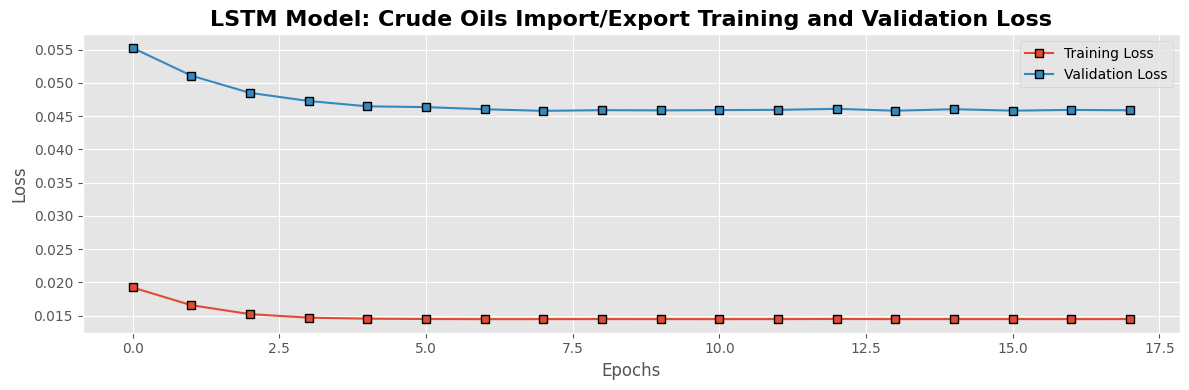

In [334]:
fig = plt.figure() 
ax = fig.add_subplot()
pd.DataFrame({'Training Loss': hist.history.get('loss') , 'Validation Loss': hist.history.get('val_loss')}).plot(marker='s', mec='black', ax=ax)
ax.set_title("LSTM Model: Crude Oils Import/Export Training and Validation Loss", fontweight='bold', fontsize=16 ) 
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.tight_layout()

## **LSTM Model WA: Correlogram and QQ-Plot**
- The WA LSTM Model can't be used to forecast the `weekly` crude oil import/exports in WA state
1. The residuals correlogram shows that there is autocorrelation after lag 6 
2. Ljungbox: All the p-value < 0.5 (lags=20)
3. The Residuals QQ-Plot is not a straight line 

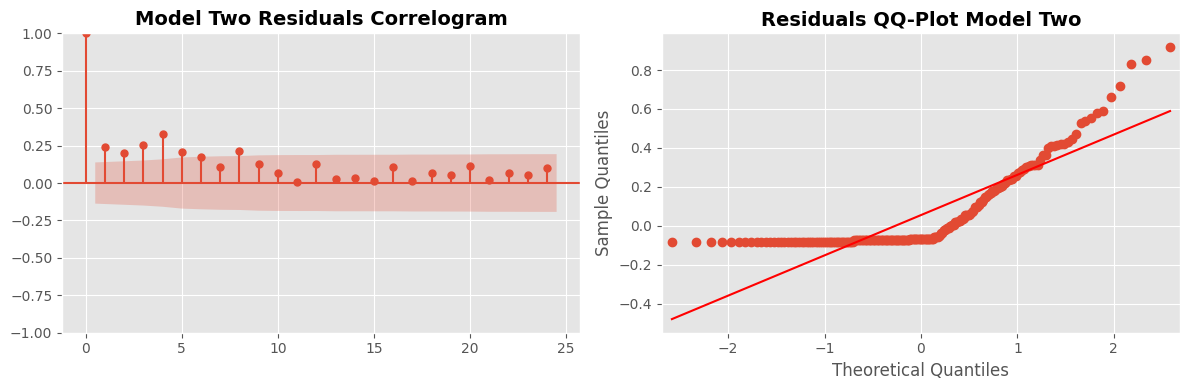

In [352]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2, 1) 
plot_acf(np.array(residuals), ax=ax)
ax.set_title("Model Two Residuals Correlogram", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2, 2)
sm.qqplot(np.array(residuals), line='s', ax=ax)
ax.set_title("Residuals QQ-Plot Model Two", fontweight='bold', fontsize=14)

plt.tight_layout()

## **Model Two: Ljungbox Test** 

In [349]:
pd.concat([acorr_ljungbox(np.array(residuals), lags=20 ), acorr_ljungbox(np.array(residuals), lags=20 ).apply(lambda row: row > 0.5).rename({'lb_pvalue': 'p-value > 0.5' }, axis=1)['p-value > 0.5'] ], axis=1)

,lb_stat,lb_pvalue,p-value > 0.5
1,11.722117,6.176166e-04,False
2,20.114826,4.286681e-05,False
3,33.684786,2.309197e-07,False
4,56.164928,1.851706e-11,False
5,65.150249,1.043126e-12,False
6,71.750633,1.787758e-13,False
7,74.158761,2.124928e-13,False
8,84.223204,6.878695e-15,False
9,87.687357,4.733775e-15,False
10,88.635917,9.979998e-15,False
